In [1]:
import torch

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

In [2]:
import torch

datasets = ['cifar100', 'ImageNet16-120', 'cifar10-valid']

for dataset in datasets:
    print(f"Processing {dataset}...")

    try:
        # Load metric tensors
        valid_acc = torch.load(f'NATS_data/sss_data/nats_{dataset}_valid_acc.pt')     # shape [N, 1]
        train_time = torch.load(f'NATS_data/sss_data/nats_{dataset}_train_time.pt')   # shape [N, 1]
        valid_time = torch.load(f'NATS_data/sss_data/nats_{dataset}_valid_time.pt')   # shape [N, 1]

        # Compute outputs
        all_y = (100-valid_acc).to(torch.float64)
        all_c = (train_time + valid_time).to(torch.float64)

        # # Save results
        torch.save(all_y, f'NATS_data/sss_data/nats_{dataset}_all_y.pt')
        torch.save(all_c, f'NATS_data/sss_data/nats_{dataset}_all_c.pt')

        print(f"  Saved all_y and all_c for {dataset} ({all_y.shape[0]} entries).\n")

    except Exception as e:
        print(f"  Failed to process {dataset}: {e}\n")


Processing cifar100...
  Saved all_y and all_c for cifar100 (32768 entries).

Processing ImageNet16-120...
  Saved all_y and all_c for ImageNet16-120 (32768 entries).

Processing cifar10-valid...
  Saved all_y and all_c for cifar10-valid (32768 entries).



In [3]:
all_y, all_c

(tensor([[23.1120],
         [19.9440],
         [18.1680],
         ...,
         [ 9.8800],
         [ 9.5000],
         [ 9.2880]]),
 tensor([[429.0794],
         [367.5264],
         [386.7419],
         ...,
         [688.2915],
         [688.6683],
         [683.0524]]))

In [4]:
import torch

datasets = ['cifar100', 'ImageNet16-120', 'cifar10-valid']

for dataset in datasets:
    print(f"Processing {dataset}...")

    try:
        # Load individual metric tensors
        test_acc = torch.load(f'NATS_data/sss_data/nats_{dataset}_test_acc.pt')       # shape [N, 1]

        # Find best test accuracy and corresponding index
        best_acc = torch.max(test_acc).item()

        print(f"  Best test accuracy: {best_acc:.2f}%\n")
        print(f"  Best test error: {(100-best_acc):.2f}%\n")
        print(f"  epsilon: {(0.05*(100-best_acc)):.2f}\n")

    except Exception as e:
        print(f"  Failed to process {dataset}: {e}\n")

Processing cifar100...
  Best test accuracy: 71.34%

  Best test error: 28.66%

  epsilon: 1.43

Processing ImageNet16-120...
  Best test accuracy: 47.40%

  Best test error: 52.60%

  epsilon: 2.63

Processing cifar10-valid...
  Best test accuracy: 90.50%

  Best test error: 9.50%

  epsilon: 0.48



In [5]:
all_x = torch.load(f'NATS_data/sss_data/nats_all_x.pt')
all_x = all_x.to(torch.float64).detach()
all_flops = torch.load(f'NATS_data/sss_data/nats_all_flops.pt')
all_flops = all_flops.to(torch.float64)
torch.save(all_x, f'NATS_data/sss_data/nats_all_x.pt')
torch.save(all_flops, f'NATS_data/sss_data/nats_all_flops.pt')

In [6]:
all_x

tensor([[2., 2., 1., 0., 0., 0.],
        [3., 1., 3., 0., 0., 0.],
        [3., 4., 4., 0., 0., 0.],
        ...,
        [3., 3., 0., 0., 0., 0.],
        [4., 4., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0.]])

Slope for cifar100: 2.0694
Slope for ImageNet16-120: 0.8285
Slope for cifar10-valid: 1.1996


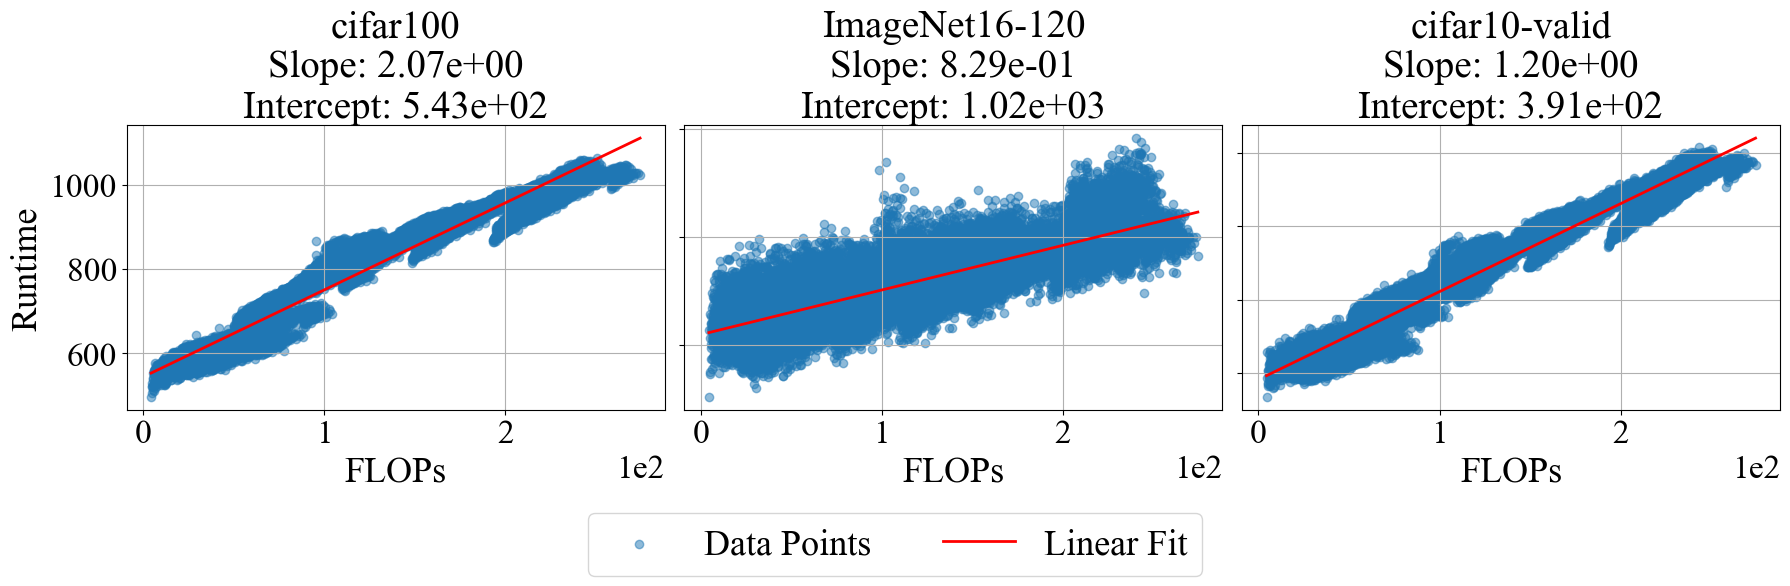

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

datasets = ['cifar100', 'ImageNet16-120', 'cifar10-valid']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

all_flops = torch.load(f'NATS_data/sss_data/nats_all_flops.pt')

for i, (ax, dataset) in enumerate(zip(axes, datasets)):
    # Load data
    train_time = torch.load(f'NATS_data/sss_data/nats_{dataset}_train_time.pt').double().squeeze()
    valid_time = torch.load(f'NATS_data/sss_data/nats_{dataset}_valid_time.pt').double().squeeze()
    all_c = (train_time + valid_time)

    x = all_flops.numpy().reshape(-1)
    y = all_c.numpy().reshape(-1)

    # Scatter
    ax.scatter(x, y, alpha=0.5, label='Data Points')

    if len(x) > 1:
        # Linear fit
        coeffs = np.polyfit(x, y, 1)
        slope, intercept = coeffs
        fit_line = np.poly1d(coeffs)
        x_range = np.linspace(min(x), max(x), 100)
        ax.plot(x_range, fit_line(x_range), color='red', linewidth=2, label='Linear Fit')
        print(f"Slope for {dataset}: {slope:.4f}")
        ax.set_title(f"{dataset}\nSlope: {slope:.2e}\nIntercept: {intercept:.2e}", fontsize=28)
    else:
        ax.set_title(f"{dataset}\nInsufficient data", fontsize=28)

    if i == 0:
        ax.set_ylabel("Runtime", fontsize=26)
    else:
        ax.set_ylabel("")
        ax.tick_params(labelleft=False)

    ax.set_xlabel("FLOPs", fontsize=26)
    ax.tick_params(axis='both', labelsize=24)
    ax.grid(True)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.xaxis.get_offset_text().set_fontsize(24)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=26, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.savefig("../plots/NATS_runtime_proxy.pdf")

In [13]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # add parent directory to path

In [14]:
from pandora_automl.utils import fit_gp_model
import numpy as np
import math
from botorch.acquisition import LogExpectedImprovement
from pandora_automl.acquisition.log_ei_puc import LogExpectedImprovementWithCost
from botorch.acquisition import UpperConfidenceBound
from pandora_automl.acquisition.lcb import LowerConfidenceBound
from pandora_automl.acquisition.gittins import GittinsIndex
from pandora_automl.acquisition.stable_gittins import StableGittinsIndex

In [15]:
from botorch.sampling.pathwise import draw_matheron_paths
import math

dim = 5
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
n_iter = 5
maximize = False
output_standardize = True
acq = "TS"
seed = 42
num_configs = 32768
epsilon = 0.042
num_samples = 64

torch.manual_seed(seed)
init_config_id = torch.randint(low=0, high=num_configs, size=(2*(dim+1),))
config_id_history = init_config_id.tolist()
print(f"  Initial config id: {config_id_history}")
x = all_x[init_config_id]
y = all_y[init_config_id]
c = all_c[init_config_id]
best_y_history = [y.min().item()]
best_id_history = [config_id_history[y.argmin().item()]]
cost_history = [0]
LogEIC_history = []

# Instead of several separate lists, we initialize a dictionary to store all acquisition histories.
acq_history = {
    'PRB': [np.nan]
}

# Independent seed for Thompson sampling
ts_seed  = seed + 1

for i in range(n_iter):
    # 1. Fit a GP model on the current data.
    model = fit_gp_model(X=x, objective_X=y, output_standardize=output_standardize)
    
    # 2. Determine the best observed objective value.
    best_f = y.min()
        
    # 3. Define the acquisition function.
    LCB = LowerConfidenceBound(model=model, maximize=maximize, beta=2 * np.log(dim * ((i + 1) ** 2) * (math.pi ** 2) / (6 * 0.1)) / 5)

    # 4. Evaluate the acquisition function on all candidate x's.
    LCB_acq = LCB.forward(all_x.unsqueeze(1))

    # 5. Record information for stopping.
    all_ids = torch.arange(num_configs)
    mask = torch.ones(num_configs, dtype=torch.bool)
    mask[config_id_history] = False

    # Probabilistic regret bound
    paths = draw_matheron_paths(model, sample_shape=torch.Size([num_samples]))
    best_x = all_x[config_id_history[y.argmin().item()]]
    regrets = paths(best_x.unsqueeze(0)).squeeze(-1) - paths(all_x).min(dim=1).values
    prb_estimate = (regrets <= epsilon).float().mean().item()
    acq_history['PRB'].append(prb_estimate)
    num_samples = min(math.ceil(num_samples * 1.5), 1000)

    # 6. Select the candidate with the optimal acquisition value.
    candidate_ids = all_ids[mask]
    
    if acq == "LCB":
        candidate_acqs = LCB_acq[mask]
        new_config_id = candidate_ids[torch.argmin(candidate_acqs)]
        new_config_acq = torch.min(candidate_acqs)

    if acq == "TS":
        prev_state = torch.get_rng_state()
        torch.manual_seed(ts_seed)
        sample_path = draw_matheron_paths(model, sample_shape=torch.Size([1]))
        torch.set_rng_state(prev_state)
        TS_acq = sample_path(all_x).squeeze()
        candidate_acqs = TS_acq[mask]
        new_config_id = candidate_ids[torch.argmin(candidate_acqs)]
        new_config_acq = torch.min(candidate_acqs)

    new_config_x = all_x[new_config_id]
    
    # 7. Query the objective for the new configuration.
    new_config_y = all_y[new_config_id]
    new_config_c = all_c[new_config_id]
    
    # 8. Append the new data to our training set.
    x = torch.cat([x, new_config_x.unsqueeze(0)], dim=0)
    y = torch.cat([y, new_config_y.unsqueeze(0)], dim=0)
    c = torch.cat([c, new_config_c.unsqueeze(0)], dim=0)
    config_id_history.append(new_config_id.item())
    best_y_history.append(best_f.item())
    best_id_history.append(config_id_history[y.argmin().item()])
    cost_history.append(new_config_c.item())

    print(f"Iteration {i + 1}:")
    print(f"  Selected config_id: {new_config_id}")
    print(f"  Acquisition value: {new_config_acq.item():.4f}")
    print(f"  Objective (final_val_error): {new_config_y.item():.4f}")
    print(f"  Cost (time): {new_config_c.item():.4f}")
    print(f"  Current best observed: {best_f.item():.4f}")
    print()

best_y_history.append(y.min().item())

  Initial config id: [23654, 15795, 860, 5390, 29802, 21575, 11964, 11284, 22118, 6265, 16850, 29910]
Iteration 1:
  Selected config_id: 26684
  Acquisition value: 9.0434
  Objective (final_val_error): 11.6640
  Cost (time): 590.4783
  Current best observed: 10.3600

Iteration 2:
  Selected config_id: 16378
  Acquisition value: 8.9593
  Objective (final_val_error): 10.7000
  Cost (time): 515.5591
  Current best observed: 10.3600

Iteration 3:
  Selected config_id: 16236
  Acquisition value: 8.7312
  Objective (final_val_error): 10.8160
  Cost (time): 514.4780
  Current best observed: 10.3600

Iteration 4:
  Selected config_id: 3533
  Acquisition value: 10.0146
  Objective (final_val_error): 12.0800
  Cost (time): 427.4567
  Current best observed: 10.3600

Iteration 5:
  Selected config_id: 20475
  Acquisition value: 10.0460
  Objective (final_val_error): 10.0480
  Cost (time): 571.6385
  Current best observed: 10.3600



In [10]:
estimated_costs = all_flops + 400
estimated_costs

tensor([[404.4811],
        [404.8949],
        [405.5258],
        ...,
        [670.3201],
        [672.3805],
        [674.3999]])

In [16]:
dim = 5
n_iter = 5
maximize = False
output_standardize = True
acq = "StablePBGI(1e-3)"
seed = 42
num_configs = 32768

torch.manual_seed(seed)
init_config_id = torch.randint(low=0, high=num_configs, size=(2*(dim+1),))
config_id_history = init_config_id.tolist()
print(f"  Initial config id: {config_id_history}")
x = all_x[init_config_id]
y = all_y[init_config_id]
c = all_c[init_config_id]
best_y_history = [y.min().item()]
best_id_history = [config_id_history[y.argmin().item()]]
cost_history = [0]
LogEIC_history = []

# Instead of several separate lists, we initialize a dictionary to store all acquisition histories.
acq_history = {
    'StablePBGI(1e-3)': [np.nan],
    'StablePBGI(1e-4)': [np.nan],
    'StablePBGI(1e-5)': [np.nan],
    'LogEIC': [np.nan],
    'regret upper bound': [np.nan]
}

for i in range(n_iter):
    # 1. Fit a GP model on the current data.
    model = fit_gp_model(X=x, objective_X=y, output_standardize=output_standardize)
    
    # 2. Determine the best observed objective value.
    best_f = y.min()
        
    # 3. Define the acquisition function.
    StablePBGI_1e_3 = StableGittinsIndex(model=model, maximize=maximize, lmbda=1e-3)
    StablePBGI_1e_4 = StableGittinsIndex(model=model, maximize=maximize, lmbda=1e-4)
    StablePBGI_1e_5 = StableGittinsIndex(model=model, maximize=maximize, lmbda=1e-5)
    LogEIC = LogExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize)
    UCB = UpperConfidenceBound(model=model, maximize=maximize, beta=2 * np.log(dim * ((i + 1) ** 2) * (math.pi ** 2) / (6 * 0.1)) / 5)
    LCB = LowerConfidenceBound(model=model, maximize=maximize, beta=2 * np.log(dim * ((i + 1) ** 2) * (math.pi ** 2) / (6 * 0.1)) / 5)

    # 4. Evaluate the acquisition function on all candidate x's.
    StablePBGI_1e_3_acq = StablePBGI_1e_3.forward(all_x.unsqueeze(1), cost_X = estimated_costs)
    StablePBGI_1e_3_acq[config_id_history] = y.squeeze(-1)
    StablePBGI_1e_4_acq = StablePBGI_1e_4.forward(all_x.unsqueeze(1), cost_X = estimated_costs)
    StablePBGI_1e_4_acq[config_id_history] = y.squeeze(-1)
    StablePBGI_1e_5_acq = StablePBGI_1e_5.forward(all_x.unsqueeze(1), cost_X = estimated_costs)
    StablePBGI_1e_5_acq[config_id_history] = y.squeeze(-1)
    LogEIC_acq = LogEIC.forward(all_x.unsqueeze(1), cost_X = estimated_costs)
    UCB_acq = UCB.forward(all_x.unsqueeze(1))
    LCB_acq = LCB.forward(all_x.unsqueeze(1))

    # 5. Record information for stopping.
    all_ids = torch.arange(num_configs)
    mask = torch.ones(num_configs, dtype=torch.bool)
    mask[config_id_history] = False

    acq_history['StablePBGI(1e-3)'].append(torch.min(StablePBGI_1e_3_acq[mask]).item())
    acq_history['StablePBGI(1e-4)'].append(torch.min(StablePBGI_1e_4_acq[mask]).item())
    acq_history['StablePBGI(1e-5)'].append(torch.min(StablePBGI_1e_5_acq[mask]).item())
    acq_history['LogEIC'].append(torch.max(LogEIC_acq[mask]).item())
    acq_history['regret upper bound'].append(torch.min(UCB_acq[~mask]).item() - torch.min(LCB_acq).item())

    # 6. Select the candidate with the optimal acquisition value.
    candidate_ids = all_ids[mask]
    
    if acq == "StablePBGI(1e-3)":
        candidate_acqs = StablePBGI_1e_3_acq[mask]
        new_config_id = candidate_ids[torch.argmin(candidate_acqs)]
        new_config_acq = torch.min(candidate_acqs)
    if acq == "StablePBGI(1e-4)":
        candidate_acqs = StablePBGI_1e_4_acq[mask]
        new_config_id = candidate_ids[torch.argmin(candidate_acqs)]
        new_config_acq = torch.min(candidate_acqs)
    if acq == "StablePBGI(1e-5)":
        candidate_acqs = StablePBGI_1e_5_acq[mask]
        new_config_id = candidate_ids[torch.argmin(candidate_acqs)]
        new_config_acq = torch.min(candidate_acqs)
    if acq == "LogEIC":
        candidate_acqs = LogEIC_acq[mask]
        new_config_id = candidate_ids[torch.argmax(candidate_acqs)]
        new_config_acq = torch.max(candidate_acqs)
    if acq == "LCB":
        candidate_acqs = LCB_acq[mask]
        new_config_id = candidate_ids[torch.argmin(candidate_acqs)]
        new_config_acq = torch.min(candidate_acqs)

    new_config_x = all_x[new_config_id]
    
    # 7. Query the objective for the new configuration.
    new_config_y = all_y[new_config_id]
    new_config_c = all_c[new_config_id]
    
    # 8. Append the new data to our training set.
    x = torch.cat([x, new_config_x.unsqueeze(0)], dim=0)
    y = torch.cat([y, new_config_y.unsqueeze(0)], dim=0)
    c = torch.cat([c, new_config_c.unsqueeze(0)], dim=0)
    config_id_history.append(new_config_id.item())
    best_y_history.append(best_f.item())
    best_id_history.append(config_id_history[y.argmin().item()])
    cost_history.append(new_config_c.item())

    print(f"Iteration {i + 1}:")
    print(f"  Selected config_id: {new_config_id}")
    print(f"  Acquisition value: {new_config_acq.item():.4f}")
    print(f"  Objective (final_val_error): {new_config_y.item():.4f}")
    print(f"  Cost (time): {new_config_c.item():.4f}")
    print(f"  Current best observed: {best_f.item():.4f}")
    print()

best_y_history.append(y.min().item())

  Initial config id: [23654, 15795, 860, 5390, 29802, 21575, 11964, 11284, 22118, 6265, 16850, 29910]
Iteration 1:
  Selected config_id: 15731
  Acquisition value: 10.9372
  Objective (final_val_error): 10.7200
  Cost (time): 530.8069
  Current best observed: 10.3600

Iteration 2:
  Selected config_id: 15859
  Acquisition value: 10.8398
  Objective (final_val_error): 10.2520
  Cost (time): 539.2293
  Current best observed: 10.3600

Iteration 3:
  Selected config_id: 16371
  Acquisition value: 10.8684
  Objective (final_val_error): 10.2560
  Cost (time): 517.3566
  Current best observed: 10.2520

Iteration 4:
  Selected config_id: 16307
  Acquisition value: 10.8608
  Objective (final_val_error): 10.4480
  Cost (time): 516.2822
  Current best observed: 10.2520

Iteration 5:
  Selected config_id: 15347
  Acquisition value: 10.9073
  Objective (final_val_error): 10.9600
  Cost (time): 532.5195
  Current best observed: 10.2520

